<a href="https://colab.research.google.com/github/excelasaph/Predicting-Road-Crash-Severity-in-Nigeria-Using-ML-Optimization-Techniques/blob/main/Summative_Intro_to_ml_%5BExcel_Asaph%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Road Crash Severity in Nigeria

### Objective: This project aims to develop and evaluate machine learning models for predicting road crash severity in Nigeria. The focus is on exploring the impact of regularization and optimization techniques on model performance, specifically in handling imbalanced data, and conducting error analysis to understand model strengths and weaknesses.


# Case Study and Implementation




## Import necessary libraries for data manipulation, visualization, deep learning, model building, callbacks, data splitting, preprocessing, traditional ML models, and evaluation metrics.

In [372]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import Image
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from xgboost import XGBClassifier
import joblib

## Install the `imbalanced-learn` library, specifically version 0.8.1, which is used for handling imbalanced datasets, such as using SMOTE.

In [373]:
# !pip install imbalanced-learn==0.8.1

In [374]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## The Dataset
### ***Brief Description:***
#### This project utilizes the Road Transport Data collected by the Federal Road Safety Corps (FRSC) in Nigeria, as made available by the National Bureau of Statistics (https://microdata.nigerianstat.gov.ng/index.php/catalog/164/study-description#metadata-description).

#### The dataset contains information on road traffic crashes, including details on crash severity (fatal, serious, minor), casualties (injured and killed), and causative factors such as speeding, poor road conditions, and others. The data appears to be presented in a structured format, specifically in an Excel file for Q3 2024.

#### The primary objective of using this dataset is to build a predictive model that can classify road crashes as either **FATAL** or **NON-FATAL** based on these causative factors, aiming to support public safety efforts and reduce fatalities in Nigeria.


## Loads the raw data from an Excel file

In [375]:
# Load Data
df_raw = pd.read_excel("Road Transport Data Q3 2024.xlsx", sheet_name="Sheet1", header=None)
df_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,329,330,331,332,333,334,335,336,337,338
0,Q4 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ROAD TRAFFIC CRASHES ON STATE BASIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,STATE,FATAL,SERIOUS,MINOR,TOTAL CASES,NUMBER INJURED,NUMBER KILLED,TOTAL CASUALTY,PEOPLE INVOLVED,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abia,10,19,1,30,146,31,177,279,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adamawa,14,63,0,77,234,36,270,443,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Extracts and processes the "Crash Data" section (rows 4-41) from the raw dataframe, identifying columns, setting headers, and separating data for each quarter.

In [376]:
# Step 1: Extract Crash Data (Rows 4–41)
crash_columns = ['STATE', 'FATAL', 'SERIOUS', 'MINOR', 'TOTAL CASES', 'NUMBER INJURED',
                 'NUMBER KILLED', 'TOTAL CASUALTY', 'PEOPLE INVOLVED']
header_row_crash = df_raw.iloc[2]  # Row 3 for headers
data_rows_crash = df_raw.iloc[3:41]  # Rows 4–41 for data

# Find columns where header is 'STATE'
state_cols_crash = [col for col in df_raw.columns if str(header_row_crash[col]).strip().upper() == 'STATE']

In [377]:
# Extract crash data for each quarter
crash_dfs = []
for state_col in state_cols_crash:
    quarter = df_raw.iloc[0, state_col]  # Quarter name from row 1
    if pd.isna(quarter):
        continue
    quarter = str(quarter).strip()
    if not (quarter.startswith('Q') and len(quarter) <= 8):
        continue
    block_cols = df_raw.columns[state_col:state_col + 9]
    if len(block_cols) == 9:
        df_quarter = data_rows_crash[block_cols].copy()
        df_quarter.columns = crash_columns
        df_quarter['QUARTER'] = quarter
        crash_dfs.append(df_quarter)

# Combine all quarters' crash data
df_crash = pd.concat(crash_dfs, ignore_index=True)

# Remove "Total" rows
df_crash = df_crash[df_crash['STATE'].str.strip().str.lower() != 'total'].dropna(subset=['STATE'])

print("Crash data shape:", df_crash.shape)
print("Crash data sample:\n", df_crash.head())

Crash data shape: (592, 10)
Crash data sample:
        STATE FATAL SERIOUS MINOR TOTAL CASES NUMBER INJURED NUMBER KILLED  \
0       Abia    10      19     1          30            146            31   
1    Adamawa    14      63     0          77            234            36   
2  Akwa Ibom     6      13     3          22             28             7   
3    Anambra    14      41    17          72            152            20   
4     Bauchi    45     108     1         154            685            90   

  TOTAL CASUALTY PEOPLE INVOLVED  QUARTER  
0            177             279  Q4 2020  
1            270             443  Q4 2020  
2             35              89  Q4 2020  
3            172             526  Q4 2020  
4            775            1182  Q4 2020  


## Extracts and processes the "Causative Factors Data" section (rows 101-138) from the raw dataframe, identifying columns, setting headers, and separating data for each quarter.

In [378]:
# Step 2: Extract Causative Factors Data (Rows 101–138)
causative_columns = ['STATE', 'SPV', 'UPWD', 'TBT', 'MDV', 'BFL', 'OVL', 'DOT', 'WOT',
                     'DGD', 'BRD', 'RTV', 'OBS', 'SOS', 'DAD', 'PWR', 'FTQ', 'SLV',
                     'OTHERS', 'TOTAL']
header_row_caus = df_raw.iloc[99]  # Row 100 for headers
data_rows_caus = df_raw.iloc[100:138]  # Rows 101–138 for data

# Find columns where header is 'STATE'
state_cols_caus = [col for col in df_raw.columns if str(header_row_caus[col]).strip().upper() == 'STATE']

# Debug: Print quarter names from row 99
print("\nRaw quarter names in row 99 (causative data):")
print(df_raw.iloc[98, state_cols_caus].tolist())


Raw quarter names in row 99 (causative data):
[nan, nan, nan, 'Q3 2021 CAUSATIVE FACTORS OF ROAD TRAFFIC CRASHES  ', 'Q4 2021 CAUSATIVE FACTORS OF ROAD TRAFFIC CRASHES  ', 'Q1 2022 CAUSATIVE FACTORS OF ROAD TRAFFIC CRASHES  ', 'Q2 2022 CAUSATIVE FACTORS OF ROAD TRAFFIC CRASHES  ', 'Q3 2022 CAUSATIVE FACTORS OF ROAD TRAFFIC CRASHES  ', 'Q4 2022 CAUSATIVE FACTORS OF ROAD TRAFFIC CRASHES  ', 'Q1 2023 CAUSATIVE FACTORS OF ROAD TRAFFIC CRASHES  ', 'Q2 2023 CAUSATIVE FACTORS OF ROAD TRAFFIC CRASHES  ', 'Q3 2023 CAUSATIVE FACTORS OF ROAD TRAFFIC CRASHES  ', 'Q4 2023 CAUSATIVE FACTORS OF ROAD TRAFFIC CRASHES  ', 'Q1 2024 CAUSATIVE FACTORS OF ROAD TRAFFIC CRASHES  ', 'Q2 2024 CAUSATIVE FACTORS OF ROAD TRAFFIC CRASHES  ', 'Q3 2024 CAUSATIVE FACTORS OF ROAD TRAFFIC CRASHES  ']


In [379]:
# Extract causative data for each quarter
causative_dfs = []
for state_col in state_cols_caus:
    quarter = df_raw.iloc[98, state_col]  # Quarter name from row 99
    if pd.isna(quarter):
        continue
    quarter = str(quarter).strip()
    if 'CAUSATIVE FACTORS' in quarter:
        quarter = quarter.split('CAUSATIVE')[0].strip()
    if not (quarter.startswith('Q') and len(quarter) <= 8):
        continue
    block_cols = df_raw.columns[state_col:state_col + 20]
    if len(block_cols) == 20:
        df_quarter = data_rows_caus[block_cols].copy()
        df_quarter.columns = causative_columns
        df_quarter['QUARTER'] = quarter
        causative_dfs.append(df_quarter)

# Combine all quarters' causative data
df_causative = pd.concat(causative_dfs, ignore_index=True)

# Remove "Total" rows
df_causative = df_causative[df_causative['STATE'].str.strip().str.lower() != 'total'].dropna(subset=['STATE'])

print("Causative data shape:", df_causative.shape)
print("Causative data sample:\n", df_causative.head())

Causative data shape: (481, 21)
Causative data sample:
        STATE SPV UPWD TBT MDV BFL OVL DOT WOT DGD  ... RTV OBS SOS DAD PWR  \
0       Abia   4    0   5   0   5   0   0   4   2  ...   3   0   0   1   0   
1    Adamawa  66    0   2   1   0   0   0  15   1  ...   4   6   0   0   0   
2  Akwa Ibom  11    0   0   0   0   0   0   0   3  ...   0   0   0   0   0   
3    Anambra  20    0   4   1  32   0   0   5   1  ...   9  56   0   3   0   
4     Bauchi  69    0   7   7   0   2   1  15   6  ...   8   0   4   0   1   

  FTQ SLV OTHERS TOTAL  QUARTER  
0   0   0      0    24  Q3 2021  
1   0   0      0    95  Q3 2021  
2   0   0      1    15  Q3 2021  
3   0   3     12   146  Q3 2021  
4   0   5      1   127  Q3 2021  

[5 rows x 21 columns]


## Merges the **processed crash** and **causative factors** dataframes based on 'STATE' and 'QUARTER' columns. Includes checks and error handling if the merge results in an empty dataframe.

In [380]:
# Step 3: Merge Crash and Causative Data
# Standardize STATE and QUARTER
df_crash['STATE'] = df_crash['STATE'].str.strip().str.upper()
df_crash['QUARTER'] = df_crash['QUARTER'].str.strip()
df_causative['STATE'] = df_causative['STATE'].str.strip().str.upper()
df_causative['QUARTER'] = df_causative['QUARTER'].str.strip()

# Merge using inner join
df_merged = pd.merge(df_crash, df_causative, on=['STATE', 'QUARTER'], how='inner')

# Check merged data
if df_merged.empty:
    print("\nUnique QUARTER values in crash data:", df_crash['QUARTER'].unique())
    print("Unique QUARTER values in causative data:", df_causative['QUARTER'].unique())
    raise ValueError("Merged dataframe is empty. Check if 'STATE' and 'QUARTER' values match.")

print("\nMerged data shape:", df_merged.shape)
print("Merged data sample:\n", df_merged.head())


Merged data shape: (481, 29)
Merged data sample:
        STATE FATAL SERIOUS MINOR TOTAL CASES NUMBER INJURED NUMBER KILLED  \
0       ABIA     7      10     3          20             62            11   
1    ADAMAWA    14      58     8          80            208            26   
2  AKWA IBOM     1       8     4          13             18             1   
3    ANAMBRA    12      39    11          62            142            17   
4     BAUCHI    39      86     5         130            627            79   

  TOTAL CASUALTY PEOPLE INVOLVED  QUARTER  ... BRD RTV OBS SOS DAD PWR FTQ  \
0             73             140  Q3 2021  ...   0   3   0   0   1   0   0   
1            234             391  Q3 2021  ...   0   4   6   0   0   0   0   
2             19              75  Q3 2021  ...   0   0   0   0   0   0   0   
3            159             411  Q3 2021  ...   0   9  56   0   3   0   0   
4            706            1010  Q3 2021  ...   1   8   0   4   0   1   0   

  SLV OTHERS TOTA

## Performs data cleaning and engineering steps on the merged data.
### This includes converting columns to numeric types, interpolating missing values, aggregating rare causative factors into 'OTHERS', calculating total causative factors, creating percentage features for causative factors, and defining a binary 'Severity' target variable **('FATAL' vs 'NON-FATAL')**.

In [381]:
# Step 4: Data Engineering
# Convert columns to numeric types
crash_numeric = ['FATAL', 'SERIOUS', 'MINOR', 'TOTAL CASES', 'NUMBER INJURED',
                 'NUMBER KILLED', 'TOTAL CASUALTY', 'PEOPLE INVOLVED']
causative_numeric = ['SPV', 'UPWD', 'TBT', 'MDV', 'BFL', 'OVL', 'DOT', 'WOT', 'DGD',
                     'BRD', 'RTV', 'OBS', 'SOS', 'DAD', 'PWR', 'FTQ', 'SLV', 'OTHERS', 'TOTAL']
for col in crash_numeric + causative_numeric:
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')

# Interpolate missing values within each state group
def quarter_to_num(quarter):
    try:
        q, year = quarter.split()
        year = int(year)
        q_num = {'Q1': 0.0, 'Q2': 0.25, 'Q3': 0.5, 'Q4': 0.75}[q]
        return year + q_num
    except:
        return np.nan

df_merged['QUARTER_NUM'] = df_merged['QUARTER'].apply(quarter_to_num)

def interpolate_group(group):
    numeric_cols = crash_numeric + causative_numeric
    group[numeric_cols] = group[numeric_cols].interpolate(method='linear')
    return group

# Apply interpolation with include_groups=False
df_merged = df_merged.groupby('STATE').apply(interpolate_group, include_groups=False).reset_index()

# Fill any remaining NaNs with the mean per quarter
for col in crash_numeric + causative_numeric:
    df_merged[col] = df_merged.groupby('QUARTER')[col].transform(lambda x: x.fillna(x.mean()))

# Define top causative factors and aggregate rare ones
top_factors = ['SPV', 'TBT', 'BFL', 'WOT', 'DGD', 'RTV', 'SLV']
rare_factors = [col for col in causative_numeric if col not in top_factors and col != 'OTHERS' and col != 'TOTAL']
df_merged['OTHERS'] = df_merged[rare_factors].sum(axis=1, numeric_only=True) + df_merged['OTHERS'].fillna(0)
df_merged = df_merged.drop(columns=rare_factors + ['TOTAL'])

# Calculate total causative factors
causative_cols = top_factors + ['OTHERS']
df_merged['TOTAL_CAUSATIVE'] = df_merged[causative_cols].sum(axis=1, numeric_only=True)

# Create percentage features
feature_cols = [f'{col}_PCT' for col in causative_cols]
for col in causative_cols:
    df_merged[f'{col}_PCT'] = df_merged[col] / df_merged['TOTAL_CAUSATIVE'].replace(0, np.nan)
df_merged[feature_cols] = df_merged[feature_cols].fillna(0)

# Define binary severity target to address class imbalance
def assign_severity(row):
    if pd.to_numeric(row['FATAL'], errors='coerce') > 0:
        return 'FATAL'
    else:
        return 'NON-FATAL'  # Combine SERIOUS and MINOR

df_merged['Severity'] = df_merged.apply(assign_severity, axis=1)

# Create the binary 'Severity' column (1 for FATAL, 0 for NON-FATAL)
df_merged['Severity'] = df_merged['Severity'].apply(lambda x: 1 if x == 'FATAL' else 0)

print("Processed data shape:", df_merged.shape)
print("NaN counts in processed data:\n", df_merged.isna().sum())

Processed data shape: (481, 30)
NaN counts in processed data:
 STATE              0
level_1            0
FATAL              0
SERIOUS            0
MINOR              0
TOTAL CASES        0
NUMBER INJURED     0
NUMBER KILLED      0
TOTAL CASUALTY     0
PEOPLE INVOLVED    0
QUARTER            0
SPV                0
TBT                0
BFL                0
WOT                0
DGD                0
RTV                0
SLV                0
OTHERS             0
QUARTER_NUM        0
TOTAL_CAUSATIVE    0
SPV_PCT            0
TBT_PCT            0
BFL_PCT            0
WOT_PCT            0
DGD_PCT            0
RTV_PCT            0
SLV_PCT            0
OTHERS_PCT         0
Severity           0
dtype: int64


## Prepare Features and Target
### Defines the feature matrix `X` using the calculated percentage features and the target vector `y` using the binary 'Severity' column.

In [382]:
# Step 5: Prepare Features and Target for Modeling
X = df_merged[feature_cols]
y = df_merged['Severity']
y = y.values

print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Check Class Distribution

In [383]:
# Check class distribution
print("\nSeverity class distribution:")
print(df_merged['Severity'].value_counts())


Severity class distribution:
Severity
1    477
0      4
Name: count, dtype: int64


## Apply SMOTE (For Class Imbalance)
### Applies the SMOTE (Synthetic Minority Over-sampling Technique) method to the feature and target data to address class imbalance by creating synthetic examples for the minority class.

In [384]:
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Resampled training data shape:", X_resampled.shape)
print("Resampled training data class distribution:")
print(pd.Series(y_resampled).value_counts())

Resampled training data shape: (954, 8)
Resampled training data class distribution:
1    477
0    477
Name: count, dtype: int64


## Splits the resampled data into training, validation, and test sets using `train_test_split`.

In [385]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# No stratification for second split to avoid ValueError
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Initializes and applies `StandardScaler` to standardize the training, validation, and test feature sets.

In [386]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

print(y_val)

(667, 8)
(143, 8)
(144, 8)
(667,)
(143,)
(144,)
[1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0
 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 0
 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1
 0 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0]


# SECTION 1: Model Architecture:

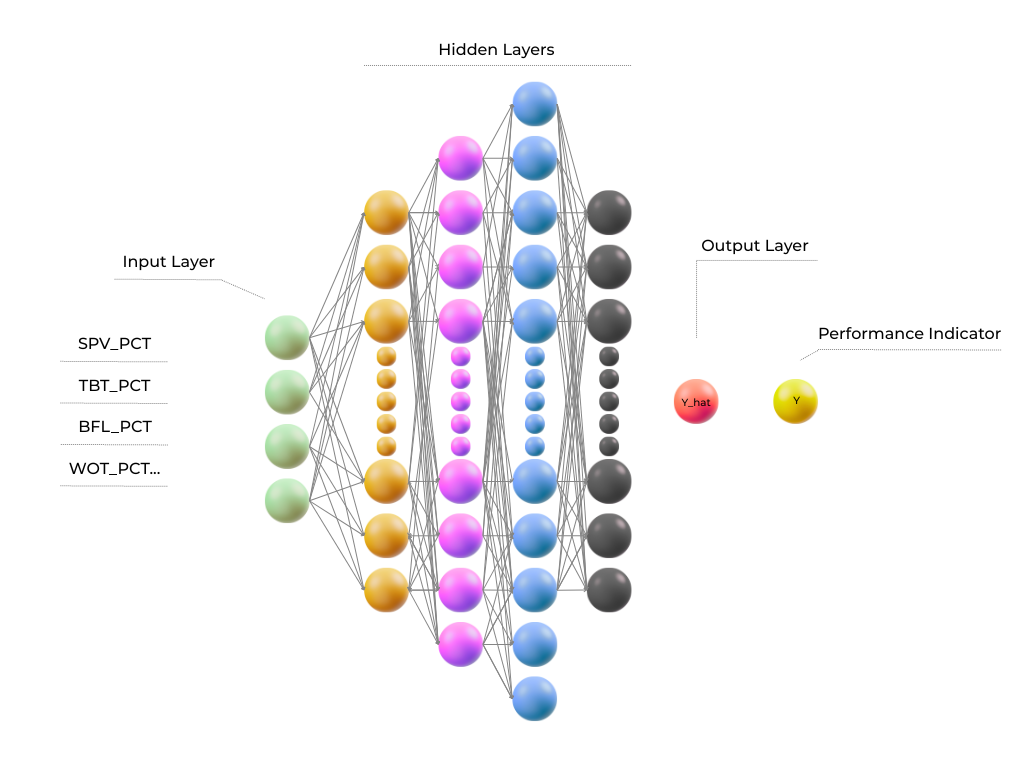

In [387]:
image_path = '/content/Road Traffic Model Architecture.png'
try:
    display(Image(filename=image_path, width=700))
except FileNotFoundError:
    print(f"Error: Image not found at {image_path}")

## Initialize Model Performance Dictionary

### Initializes an empty dictionary `model_performance` to store the evaluation metrics (specifically F1-score) for each trained model.

In [388]:
# Dictionary to store model performance metrics (e.g., F1-score)
model_performance = {}

### Creates the `/content/sample_data/saved_models/` directory to save each models.

In [389]:
import os
if not os.path.exists('/content/sample_data/saved_models'):
    os.makedirs('/content/sample_data/saved_models')

## Optimized SVM Model

### Train and Evaluate Optimized SVM

### Defines, trains, and evaluates an **Optimized SVM model** on the training and validation data. Calculates and prints accuracy, F1-score, precision, and recall on the validation set.

In [390]:
# Optimized SVM
svm_model = SVC(C=5, kernel='sigmoid', gamma=0.5, probability=True, class_weight='balanced')
svm_model.fit(X_train, y_train)
svm_val_pred = svm_model.predict(X_val)
svm_accuracy = accuracy_score(y_val, svm_val_pred)
svm_f1 = f1_score(y_val, svm_val_pred)
svm_precision = precision_score(y_val, svm_val_pred)
svm_recall = recall_score(y_val, svm_val_pred)
print(f"SVM - Accuracy: {svm_accuracy:.4f}, F1: {svm_f1:.4f}, Precision: {svm_precision:.4f}, Recall: {svm_recall:.4f}")

SVM - Accuracy: 0.4615, F1: 0.5032, Precision: 0.5000, Recall: 0.5065


### Store SVM Performance

In [391]:
# Store SVM F1 score for comparison
model_performance['SVM'] = svm_f1

# Save Model
joblib.dump(svm_model, '/content/sample_data/saved_models/svm_optimized_model.pkl')
print("Saved 'Optimized SVM Model' to /content/sample_data/saved_models/svm_optimized_model.pkl")

Saved 'Optimized SVM Model' to /content/sample_data/saved_models/svm_optimized_model.pkl


### Plot SVM Confusion Matrix

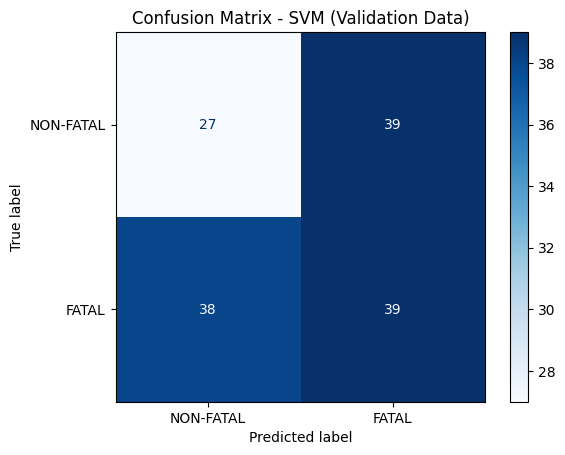

In [392]:
cm_svm = confusion_matrix(y_val, svm_val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["NON-FATAL", "FATAL"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - SVM (Validation Data)')
plt.show()

### Print SVM Classification Report

In [393]:
print("Classification Report - SVM (Validation Data):")
print(classification_report(y_val, svm_val_pred, target_names=["NON-FATAL", "FATAL"]))

Classification Report - SVM (Validation Data):
              precision    recall  f1-score   support

   NON-FATAL       0.42      0.41      0.41        66
       FATAL       0.50      0.51      0.50        77

    accuracy                           0.46       143
   macro avg       0.46      0.46      0.46       143
weighted avg       0.46      0.46      0.46       143



## No Optimization Model

### Defines a Python function `no_optimization_model()` that creates a simple Sequential neural network model with basic Dense layers and an Adam optimizer.

In [394]:
def no_optimization_model():
  model= Sequential()
  model.add(Dense(8, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(12, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [395]:
model_1 = no_optimization_model()
history = model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.5647 - loss: 0.6659 - val_accuracy: 0.6783 - val_loss: 0.6255
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7341 - loss: 0.6099 - val_accuracy: 0.7692 - val_loss: 0.5843
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8457 - loss: 0.5433 - val_accuracy: 0.8042 - val_loss: 0.5304
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8704 - loss: 0.4850 - val_accuracy: 0.9161 - val_loss: 0.4643
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8999 - loss: 0.4328 - val_accuracy: 0.9580 - val_loss: 0.3944
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9506 - loss: 0.3499 - val_accuracy: 0.9580 - val_loss: 0.3352
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9610 - loss: 0.2782 - val_accuracy: 0.9650 - val_loss: 0.2851
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9531 - loss: 0.2513 - val_accuracy: 0.9650 - val_loss: 0.2444


In [396]:
loss, accuracy = model_1.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9881 - loss: 0.1124 


### Evaluate 'No Optimization Model' on Validation and Store Performance

In [397]:
# Evaluate on validation data for F1 score
y_val_pred_0 = (model_1.predict(X_val) > 0.5).astype(int)
f1_1 = f1_score(y_val, y_val_pred_0)
print(f"No Optimization Model - F1 on Validation: {f1_1:.4f}")

# Store Model_1 F1 score for comparison
model_performance['No_Optimization'] = f1_1

# Save Model
model_1.save('/content/sample_data/saved_models/no_optimization_model.keras')
print("Saved 'No Optimization Model' to /content/sample_data/saved_models/no_optimization_model.keras")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
No Optimization Model - F1 on Validation: 0.9595
Saved 'No Optimization Model' to /content/sample_data/saved_models/no_optimization_model.keras


### Plot 'No Optimization Model' Results

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


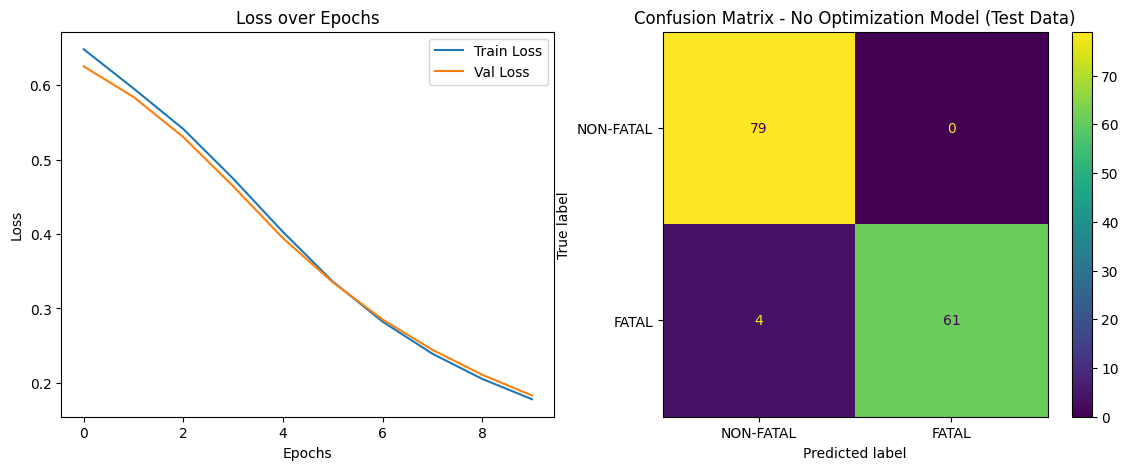

In [398]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Val Loss')
axs[0].set_title('Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

y_pred = model_1.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NON-FATAL", "FATAL"])
disp.plot(ax=axs[1])
axs[1].set_title('Confusion Matrix - No Optimization Model (Test Data)')

plt.show()

### Print 'No Optimization Model' Classification Report

In [399]:
print("Classification Report - No Optimization Model (Test Data):")
report = classification_report(y_test, y_pred_binary, target_names=["NON-FATAL", "FATAL"])
print(report)

Classification Report - No Optimization Model (Test Data):
              precision    recall  f1-score   support

   NON-FATAL       0.95      1.00      0.98        79
       FATAL       1.00      0.94      0.97        65

    accuracy                           0.97       144
   macro avg       0.98      0.97      0.97       144
weighted avg       0.97      0.97      0.97       144



# SECTION 2: Optimization and Regularization Combinations

## Optimized Model 1

### Defines a Python function `optimized_model_1()` that creates a Sequential neural network with L1 regularization on the first Dense layer and an Adam optimizer with a specified learning rate.

In [400]:
def optimized_model_1():
  model= Sequential()
  model.add(Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.05), input_shape=(X_train.shape[1],)))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(12, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  optimizer = Adam(learning_rate=0.5)

  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [401]:
model_2 = optimized_model_1()
early_stop_1 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_2 = model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stop_1])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4645 - loss: 1.9341 - val_accuracy: 0.4615 - val_loss: 1.2006
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5450 - loss: 1.1213 - val_accuracy: 0.5385 - val_loss: 0.9204
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5220 - loss: 0.8901 - val_accuracy: 0.5385 - val_loss: 0.8486
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4861 - loss: 0.8758 - val_accuracy: 0.4615 - val_loss: 0.8774
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5220 - loss: 0.8719 - val_accuracy: 0.4615 - val_loss: 0.8728
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4966 - loss: 0.8672 - val_accuracy: 0.5385 - val_loss: 0.8756


In [402]:
loss, accuracy = model_2.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4612 - loss: 0.8641 


### Evaluate 'Optimized Model 1' on Validation and Store Performance

In [403]:
# Evaluate on validation data for F1 score
y_val_pred_0 = (model_2.predict(X_val) > 0.5).astype(int)
f1_2 = f1_score(y_val, y_val_pred_0)
print(f"Optimized Model 1 - F1 on Validation: {f1_2:.4f}")

# Store Model_2 F1 score for comparison
model_performance['Optimized_NN1'] = f1_2

# Save Model
model_2.save('/content/sample_data/saved_models/optimized_nn1_model.keras')
print("Saved 'No Optimization Model' to /content/sample_data/saved_models/optimized_nn1_model.keras")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Optimized Model 1 - F1 on Validation: 0.7000
Saved 'No Optimization Model' to /content/sample_data/saved_models/optimized_nn1_model.keras


### Plot 'Optimized Model 1' Results

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


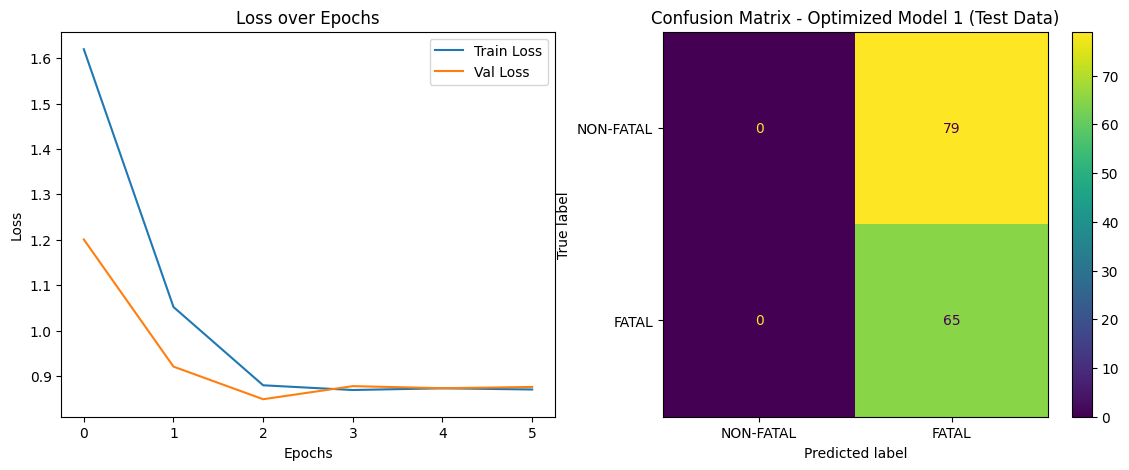

In [404]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(history_2.history['loss'], label='Train Loss')
axs[0].plot(history_2.history['val_loss'], label='Val Loss')
axs[0].set_title('Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

y_pred = model_2.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NON-FATAL", "FATAL"])
disp.plot(ax=axs[1])
axs[1].set_title('Confusion Matrix - Optimized Model 1 (Test Data)')

plt.show()

### Print 'Optimized Model 1' Classification Report

In [405]:
print("Classification Report - Optimized Model 1 (Test Data):")
report = classification_report(y_test, y_pred_binary, target_names=["NON-FATAL", "FATAL"])
print(report)

Classification Report - Optimized Model 1 (Test Data):
              precision    recall  f1-score   support

   NON-FATAL       0.00      0.00      0.00        79
       FATAL       0.45      1.00      0.62        65

    accuracy                           0.45       144
   macro avg       0.23      0.50      0.31       144
weighted avg       0.20      0.45      0.28       144



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Optimized Model 2

### Defines a Python function `optimized_model_2()` that creates a Sequential neural network with L2 regularization on the first Dense layer, a Dropout layer, and an RMSprop optimizer with a specified learning rate.

In [406]:
def optimized_model_2():
  model= Sequential()
  model.add(Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.009), input_shape=(X_train.shape[1],)))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(12, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  optimizer = RMSprop(learning_rate=0.08)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [407]:
model_3 = optimized_model_2()
early_stop_2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_3 = model_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[early_stop_2])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7449 - loss: 0.5879 - val_accuracy: 0.8462 - val_loss: 0.4448
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9086 - loss: 0.3502 - val_accuracy: 0.8322 - val_loss: 0.4750
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8960 - loss: 0.3634 - val_accuracy: 0.9371 - val_loss: 0.2230
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9153 - loss: 0.2920 - val_accuracy: 0.7902 - val_loss: 0.8190
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9083 - loss: 0.3409 - val_accuracy: 0.9301 - val_loss: 0.3101
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9171 - loss: 0.3342 - val_accuracy: 0.9231 - val_loss: 0.3033
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9322 - loss: 0.2921 - val_accuracy: 0.8951 - val_loss: 0.4797
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9638 - loss: 0.2014 - val_accuracy: 0.9161 - val_loss: 0.3080


In [408]:
loss, accuracy = model_3.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9708 - loss: 0.1574


### Evaluate Optimized Model 2 on Validation and Store Performance

In [409]:
# Evaluate on validation data for F1 score
y_val_pred_0 = (model_3.predict(X_val) > 0.5).astype(int)
f1_3 = f1_score(y_val, y_val_pred_0)
print(f"Optimized Model 2 - F1 on Validation: {f1_3:.4f}")

# Store Model_3 F1 score for comparison
model_performance['Optimized_NN2'] = f1_3

# Save Model
model_3.save('/content/sample_data/saved_models/optimized_nn2_model.keras')
print("Saved 'Optimized Model 2' to /content/sample_data/saved_models/optimized_nn2_model.keras")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Optimized Model 2 - F1 on Validation: 0.9419
Saved 'Optimized Model 2' to /content/sample_data/saved_models/optimized_nn2_model.keras


### Plot 'Optimized Model 2' Results

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


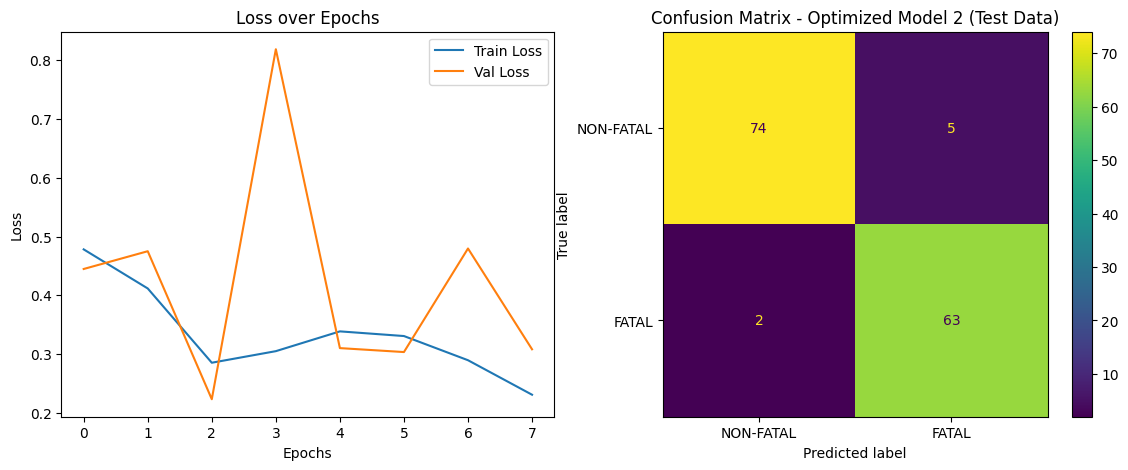

In [410]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(history_3.history['loss'], label='Train Loss')
axs[0].plot(history_3.history['val_loss'], label='Val Loss')
axs[0].set_title('Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

y_pred = model_3.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NON-FATAL", "FATAL"])
disp.plot(ax=axs[1])
axs[1].set_title('Confusion Matrix - Optimized Model 2 (Test Data)')

plt.show()

### Print 'Optimized Model 2' Classification Report

In [411]:
print("Classification Report - Optimized Model 2 (Test Data):")
report = classification_report(y_test, y_pred_binary, target_names=["NON-FATAL", "FATAL"])
print(report)

Classification Report - Optimized Model 2 (Test Data):
              precision    recall  f1-score   support

   NON-FATAL       0.97      0.94      0.95        79
       FATAL       0.93      0.97      0.95        65

    accuracy                           0.95       144
   macro avg       0.95      0.95      0.95       144
weighted avg       0.95      0.95      0.95       144



## Optimized XGBoost Model

### Defines, trains, and evaluates an Optimized XGBoost model on the training and validation data with specific hyperparameters. Calculates and prints accuracy, F1-score, precision, and recall on the validation set.

In [412]:
# Optimized XGBoost
xgb_model = XGBClassifier(max_depth=3, learning_rate=0.02, n_estimators=100, subsample=0.5, colsample_bytree=0.4)
xgb_model.fit(X_train, y_train)
xgb_val_pred = xgb_model.predict(X_val)
xgb_accuracy = accuracy_score(y_val, xgb_val_pred)
xgb_f1 = f1_score(y_val, xgb_val_pred)
xgb_precision = precision_score(y_val, xgb_val_pred)
xgb_recall = recall_score(y_val, xgb_val_pred)
print(f"XGBoost - Accuracy: {xgb_accuracy:.4f}, F1: {xgb_f1:.4f}, Precision: {xgb_precision:.4f}, Recall: {xgb_recall:.4f}")

XGBoost - Accuracy: 0.9720, F1: 0.9733, Precision: 1.0000, Recall: 0.9481


### Store XGBoost Performance

In [413]:
# Store XGBoost F1 score for comparison
model_performance['XGBoost'] = xgb_f1

# Save Model
joblib.dump(svm_model, '/content/sample_data/saved_models/svm_optimized_model.pkl')
print("Saved 'Optimized SVM Model' to /content/sample_data/saved_models/svm_optimized_model.pkl")

Saved 'Optimized SVM Model' to /content/sample_data/saved_models/svm_optimized_model.pkl


### Plot XGBoost Confusion Matrix

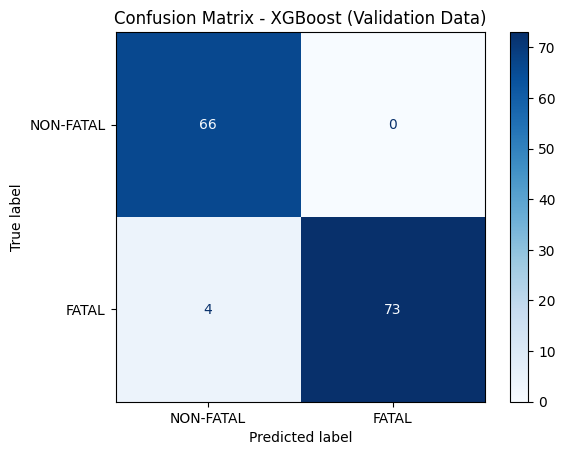

In [414]:
cm_xgb = confusion_matrix(y_val, xgb_val_pred)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["NON-FATAL", "FATAL"])
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - XGBoost (Validation Data)')
plt.show()

### Print XGBoost Classification Report

In [415]:
print("Classification Report - XGBoost (Validation Data):")
print(classification_report(y_val, xgb_val_pred, target_names=["NON-FATAL", "FATAL"]))

Classification Report - XGBoost (Validation Data):
              precision    recall  f1-score   support

   NON-FATAL       0.94      1.00      0.97        66
       FATAL       1.00      0.95      0.97        77

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



## Determine Best Model

### Finds the model name with the highest F1-score from the `model_performance` dictionary and prints the best performing model's name and F1-score.

In [416]:
# Determine the best model based on Validation F1-score
best_model_name = max(model_performance, key=model_performance.get)
best_f1_score = model_performance[best_model_name]

print(f"\nBest performing model on Validation F1-score is: {best_model_name} with F1 = {best_f1_score:.4f}")


Best performing model on Validation F1-score is: XGBoost with F1 = 0.9733


### Save Best Model

In [417]:
# Save the best model
best_model_path = f'/content/sample_data/saved_models/{best_model_name.lower()}_best_model'

if best_model_name == 'SVM':
    # Save Scikit-learn/XGBoost model using joblib
    joblib.dump(svm_model, best_model_path + '.pkl')
    print(f"Saved {best_model_name} model to {best_model_path}.pkl")
elif best_model_name == 'XGBoost':
     # Save Scikit-learn/XGBoost model using joblib
    joblib.dump(xgb_model, best_model_path + '.pkl')
    print(f"Saved {best_model_name} model to {best_model_path}.pkl")
elif best_model_name == 'No_Optimization':
    # Save Keras model
    model_1.save(best_model_path + '.keras') # Use .h5 or a directory format
    print(f"Saved {best_model_name} model to {best_model_path}.keras")
elif best_model_name == 'Optimized_NN1':
    # Save Keras model
    model_2.save(best_model_path + '.keras')
    print(f"Saved {best_model_name} model to {best_model_path}.keras")
elif best_model_name == 'Optimized_NN2':
    # Save Keras model
    model_3.save(best_model_path + '.keras')
    print(f"Saved {best_model_name} model to {best_model_path}.keras")
else:
    print("Could not identify the best model based on the stored names.")

Saved XGBoost model to /content/sample_data/saved_models/xgboost_best_model.pkl


##Make Predictions using the best saved model


### Defines a function `make_predictions` to load a model (either sklearn/joblib or keras) and make predictions.

### It then identifies the type of the best saved model, constructs the save path, loads the best model, makes predictions on the test set, calculates and prints various evaluation metrics (accuracy, F1, precision, recall) on the test set, and finally plots a confusion matrix for the best model on the test data. Includes error handling for file not found and other exceptions.


Loading model from /content/sample_data/saved_models/xgboost_best_model.pkl
Predictions made successfully.

Evaluating Best Model on Test Data:
Test Accuracy: 0.9931
Test F1 Score: 0.9922
Test Precision: 1.0000
Test Recall: 0.9846


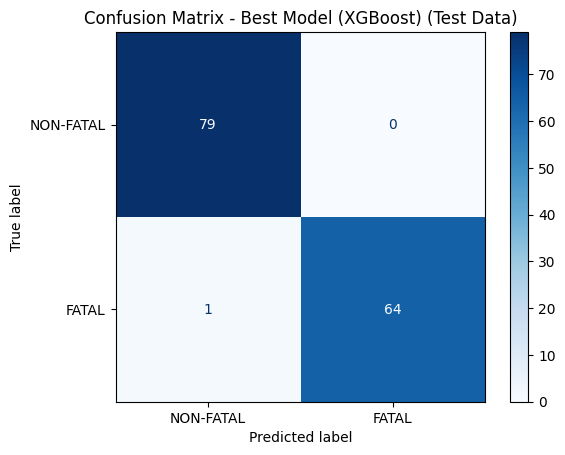

In [418]:
def make_predictions(model_path, X_test_data, model_type):
    """
    Loads a saved model and makes predictions.

    Args:
        model_path (str): Path to the saved model file.
        X_test_data (np.ndarray): The test feature data (should be scaled).
        model_type (str): Type of model ('sklearn', 'keras').

    Returns:
        np.ndarray: The predicted labels (binary).
    """
    print(f"\nLoading model from {model_path}")
    model = None
    if model_type == 'sklearn': # Covers SVM and XGBoost saved with joblib
        model = joblib.load(model_path)
        # For SVM/XGBoost, predict directly
        predictions = model.predict(X_test_data)
    elif model_type == 'keras':
        model = load_model(model_path)
        # Keras models predict probabilities, convert to binary
        probabilities = model.predict(X_test_data)
        predictions = (probabilities > 0.5).astype(int)
    else:
        raise ValueError("Invalid model_type specified. Use 'sklearn' or 'keras'.")

    print("Predictions made successfully.")
    return predictions

# Determine the type of the best model based on its name
best_model_type = 'keras' if 'NN' in best_model_name or best_model_name == 'No_Optimization' else 'sklearn'
best_model_save_path = f'/content/sample_data/saved_models/{best_model_name.lower()}_best_model'
# Add file extension based on type
if best_model_type == 'sklearn':
    best_model_save_path += '.pkl'
elif best_model_type == 'keras':
    best_model_save_path += '.keras'


# Make predictions on the test set using the best model
try:
    test_predictions = make_predictions(best_model_save_path, X_test, best_model_type)

    # Evaluate performance on the test set
    print("\nEvaluating Best Model on Test Data:")
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_f1 = f1_score(y_test, test_predictions)
    test_precision = precision_score(y_test, test_predictions)
    test_recall = recall_score(y_test, test_predictions)

    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

    # Confusion matrix and report for the best model on test data
    cm_best = confusion_matrix(y_test, test_predictions)
    disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=["NON-FATAL", "FATAL"])
    disp_best.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - Best Model ({best_model_name}) (Test Data)')
    plt.show()

except FileNotFoundError:
    print(f"Error: The best model file was not found at {best_model_save_path}. Please ensure the saving step was successful.")
except Exception as e:
    print(f"An error occurred during loading or prediction: {e}")

Congratulations!!
